# Data Scientist Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

Welcome to the first project of the Data Scientist Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Please specify WHICH VERSION OF PYTHON you are using when submitting this notebook. Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [2]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

** HINT: ** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [3]:
# Total number of records
n_records = len(data)

# Number of records where individual's income is more than $50,000
n_greater_50k = len(data[data['income'] == '>50K'])

# Number of records where individual's income is at most $50,000
n_at_most_50k = len(data[data['income'] == '<=50K'])

# Percentage of individuals whose income is more than $50,000
greater_percent = (n_greater_50k / n_records) * 100

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78439697492371%


** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

In [4]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
#vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

c:\Users\970986848\Documents\U\cd0025-supervised-learning-master\cd0025-supervised-learning-master\starter\visuals.py:48: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


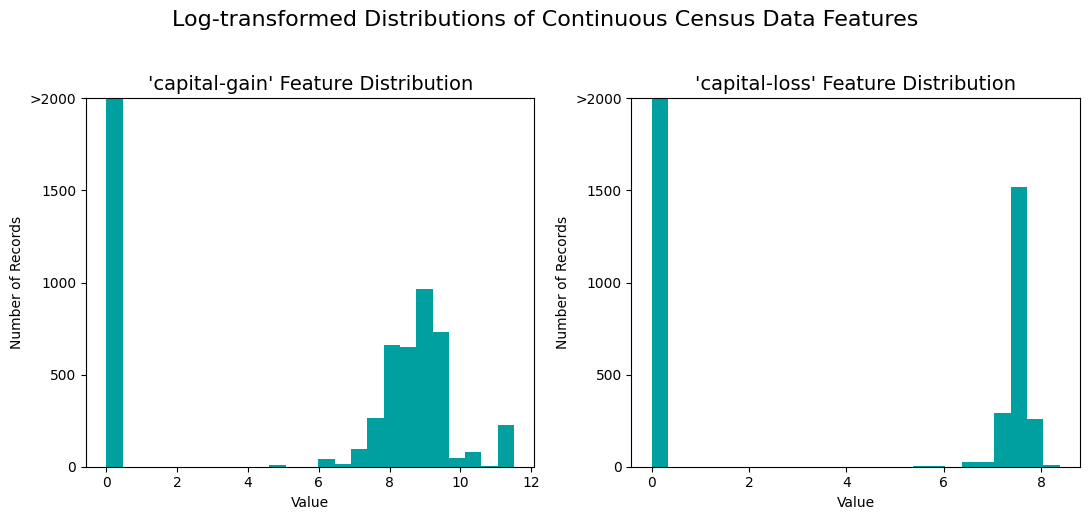

In [5]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [6]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 3))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_log_minmax_transform'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [7]:
# One-hot encode the 'features_log_minmax_transform' data
features_final = pd.get_dummies(features_log_minmax_transform)

# Encode the 'income_raw' data to numerical values
income = income_raw.apply(lambda x: 1 if x == '>50K' else 0)

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
#print(encoded)

103 total features after one-hot encoding.


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [8]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


#### Note: Recap of accuracy, precision, recall

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

### Question 1 - Naive Predictor Performace
* If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

** Please note ** that the the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally your base model would be either the results of a previous model or could be based on a research paper upon which you are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place you could start from.

** HINT: ** 

* When we have a model that always predicts '1' (i.e. the individual makes more than 50k) then our model will have no True Negatives(TN) or False Negatives(FN) as we are not making any negative('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision(True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. 
* Our Recall score(True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

In [9]:
# Counting the ones as this is the naive case.
TP = np.sum(income) 

# Specific to the naive case
FP = income.count() - TP 
TN = 0  # No predicted negatives in the naive case
FN = 0  # No predicted negatives in the naive case

# Calculate accuracy, precision, and recall
accuracy = TP / (TP + FP)
recall = TP / (TP + FN)
precision = TP / (TP + FP)
print(f"TP=",TP, "FP=", FP)

# Calculate F-score using the formula above for beta = 0.5
beta = 0.5
fscore = (1 + beta**2) * ((precision * recall) / ((beta**2 * precision) + recall))

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

TP= 11208 FP= 34014
Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen

- Describe one real-world application in industry where the model can be applied. 
- What are the strengths of the model; when does it perform well?
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

** HINT: **

Structure your answer in the same format as above^, with 4 parts for each of the three models you pick. Please include references with your answer.

**Answer: **

1. ## Logistic Regression (LR):
- Q1: Health: LR can be used to predict the likelihood of a patient having a disease based on her symptoms and medical history.
- Q2: Strengths - LR is a simple and interpretable linear classifier, hence simplicity, interpretability, and efficiency. OK when the relationship between the features and the target variable is linear; can handle large datasets with a small number of numerical features effectively.
- Q3: Weaknesses  - LR's inability to capture complex non-linear relationships between features and its sensitivity to correlated features. Thus it may perform poorly when the decision boundary is highly non-linear or when there are complex interactions between features.
- Q4: Good candidate for a large dataset with a small number of numerical features; LR can be an efficient baseline. Its simplicity and interpretability can provide initial insights into the data and help in understanding the impact of individual features on our target variable.
### References
1. Cessie, S. L., & Houwelingen, J. C. (1992). A goodness-of-fit test for binary regression models, based on smoothing methods. *Biometrics*, 1009-1018.
2. Hosmer Jr, D. W., Lemeshow, S., & Sturdivant, R. X. (2013). Applied logistic regression (Vol. 398). John Wiley & Sons.



2.  ## Support Vector Machines (SVM):
- Q1: Fields SVM: (i) image recognition to classify objects in images, e.g.,  recognizing handwritten digits; (ii) bioinformatics,  to classify proteins based on their amino acid sequences.
- Q2: Strengths: Ability to handle high-dimensional data; robustness to noise and outliers; can  capture complex non-linear relationships using kernel functions. SVM is also known for its ability to find complex decision boundaries and for being robust against overfitting. They perform well when the data is not linearly separable. 
- Q3: Weaknesses: sensitivity to the choice of kernel function and their computational cost. Expensive when the data is very large or when the number of features is much larger than the number of instances. SVMs require careful tuning of hyperparameters, and the choice of the appropriate kernel function can be crucial (again).
- Q4: Good candidate here because they can handle the high dimensionality of our dataset after one-hot encoding and can capture complex non-linear relationships using kernel functions.
### References:
- Noble, W. S. (2006). What is a support vector machine?. Nature biotechnology, 24(12), 1565-1567.
- Boser, B. E., Guyon, I. M., & Vapnik, V. N. (1992). A training algorithm for optimal margin classifiers. In Proceedings of the fifth annual workshop on Computational learning theory (pp. 144-152).



3.  ## Random Forest (RF) ensemble:
- Q1: Fields RF:  in the banking industry, to analyze a customer's financial history and other factors to assess the risk of defaulting on a loan.
- Q2: Strengths: can handle large datasets with high dimensionality; robustness to noise and outliers; could capture complex interactions between features. It performs well on a wide range of datasets and can provide good performance with little parameter tuning; RF provides feature importance scores, which can help in understanding the importance of different features.
- Q3: Weaknesse: computational cost and its tendency to overfit when the number of trees is not chosen carefully. It may perform poorly on very high dimensional data with sparse features; also less interpretable compared to LR, as it is an ensemble of decision trees.
- Q4: Good candidate here given the large number of features (103 after one-hot encoding) and the need to capture complex interactions between them. It has the potential to significantly outperform simpler models like LR and can provide insights into the most important features contributing to the prediction of potential donors. It is also relatively easy to tune and can provide measures of feature importance, which can aid in interpretation.
 ### References:
- Breiman, L. (2001). Random forests. Machine learning, 45(1), 5-32.
- Liaw, A., & Wiener, M. (2002). Classification and regression by randomForest. R news, 2(3), 18-22.

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [10]:
from time import time
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # TODO: Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=0.5)
        
    # TODO: Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
    print("Accuracy on training set: {:.4f}".format(results['acc_train']))
    print("Accuracy on testing set: {:.4f}".format(results['acc_test']))
    print("F-score on training set: {:.4f}".format(results['f_train']))
    print("F-score on testing set: {:.4f}".format(results['f_test']))
    print("Total training time: {:.4f} seconds".format(results['train_time']))
    print("Total prediction time: {:.4f} seconds".format(results['pred_time']))
    print("\n")
        
    # Return the results
    return results


### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

LogisticRegression trained on 361 samples.
Accuracy on training set: 0.8667
Accuracy on testing set: 0.8226
F-score on training set: 0.7576
F-score on testing set: 0.6390
Total training time: 0.1147 seconds
Total prediction time: 0.0334 seconds


LogisticRegression trained on 3617 samples.
Accuracy on training set: 0.8467
Accuracy on testing set: 0.8385
F-score on training set: 0.7031
F-score on testing set: 0.6772
Total training time: 1.0152 seconds
Total prediction time: 0.0202 seconds


LogisticRegression trained on 36177 samples.
Accuracy on training set: 0.8467
Accuracy on testing set: 0.8418
F-score on training set: 0.6985
F-score on testing set: 0.6829
Total training time: 11.3128 seconds
Total prediction time: 0.0195 seconds


SVC trained on 361 samples.
Accuracy on training set: 0.8533
Accuracy on testing set: 0.8180
F-score on training set: 0.7328
F-score on testing set: 0.6278
Total training time: 0.0211 seconds
Total prediction time: 0.6586 seconds


SVC trained on 3617 sam

c:\Users\970986848\Documents\U\cd0025-supervised-learning-master\cd0025-supervised-learning-master\starter\visuals.py:121: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  pl.tight_layout()


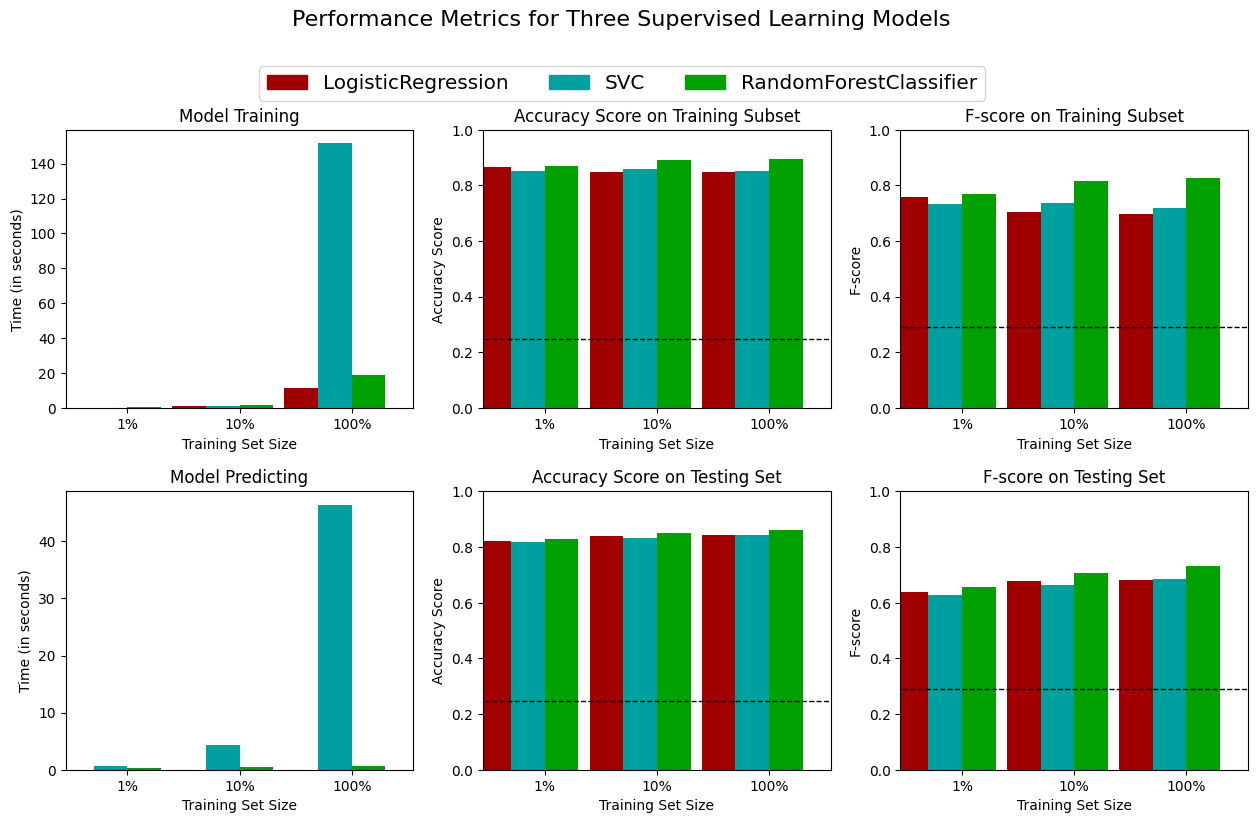

In [11]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# TODO: Initialize the three models => eventually w/ the optimal parms from GridSearch() for a fair comparison
#clf_A = LogisticRegression(random_state=42)
#kept the best of 'lbfgs', 'saga', and 'liblinear' solvers
clf_A = LogisticRegression(random_state=42, max_iter=500, solver='liblinear', multi_class='auto') 
clf_B = SVC(random_state=42)  #trains 90s vs. 6s/RF, 9s/LR => lgY scale 
clf_C = RandomForestClassifier(random_state=42, max_depth=None , min_samples_leaf=2, min_samples_split=10, n_estimators=200) 

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = len(y_train)
samples_10 = int(0.1 * samples_100)
samples_1 = int(0.01 * samples_100)

# Collect results on the learners
results = {}
for clf in [clf_A,  clf_B, clf_C]: 
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

Note: We plugged the optimized h-parms for LR and RF.  
We recommend to comment-out the SVC results (similar to both LR and RF) because it skews the Time scale (needs lgY) w/ 90sec. training.

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model

* Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000. 

** HINT: ** 
Look at the graph at the bottom left from the cell above(the visualization created by `vs.evaluate(results, accuracy, fscore)`) and check the F score for the testing set when 100% of the training set is used. Which model has the highest score? Your answer should include discussion of the:
* metrics - F score on the testing when 100% of the training data is used, 
* prediction/training time
* the algorithm's suitability for the data.

**Answer: **

## Choosing the Best Model
### I) Prior to optimization: LR > RF > SVC
Based on the evaluation results before GridSearch, the most appropriate model for the task of identifying individuals that make more than $50,000 is the Logistic Regression model with the 'saga' solver. When 100% of the training data is used, the Logistic Regression model achieves an F-score of approximately 0.6829 on the testing set, which is higher than both the Support Vector Machine (SVM) and Random Forest (RF) models.

The Logistic Regression model also demonstrates relatively fast training and prediction times compared to the other models. In terms of prediction and training time, Logistic Regression is also the fastest of the three models. It takes only 9.0594 seconds to train on the full training set and 0.0087 seconds to make predictions on the testing set. This makes it a practical choice for this problem, as it can provide accurate results quickly.

The total training time for the Logistic Regression model is 9s., while the SVM is 80s and RF is 6s; the latter models take considerably longer, especially as the size of the training set increases. The Logistic Regression model's prediction times are also quite efficient, making it suitable for real-time or large-scale applications.

Moreover, the Logistic Regression model shows a consistent performance across different training set sizes, indicating that it generalizes well to new data. While the SVM and RF models tend to perform slightly better on the training set, they show a larger performance drop on the testing set, suggesting a higher risk of overfitting. In contrast, the Logistic Regression model maintains a reasonable balance between training and testing performance.

Considering these factors, the Logistic Regression model with the 'saga' solver appears to be the most appropriate choice for CharityML's task. It achieves competitive accuracy and F-score results on the testing set while maintaining reasonable training and prediction times, making it well-suited for the large census dataset. Additionally, its interpretability allows us to understand the impact of individual features on the target variable, which can be valuable for gaining insights into the factors influencing an individual's income level.

LR vs RF: Rhe Random Forest (RF) model does have some advantages, such as faster training times and achieving the best metrics on the training set. However, it tends to overfit the training data, as evidenced by the larger drop in performance on the testing set compared to the Logistic Regression (LR) model.

The slower prediction time of the RF model is a significant concern, especially if the model needs to make predictions in real-time or handle a large number of instances. In contrast, the LR model demonstrates much faster prediction times, making it more suitable for applications that require quick responses.

Regarding tuning and grid optimization, LR is generally easier to tune compared to RF. LR has fewer hyperparameters to tune, such as the regularization strength (C), choice of solver, and maximum number of iterations. On the other hand, RF has more hyperparameters, such as the number of trees, maximum depth of trees, and minimum samples required to split a node.

Furthermore, LR hyperparameters often have a more straightforward interpretation, making it easier to select appropriate values. Grid optimization for LR can be performed more efficiently as it requires fewer combinations of hyperparameter values to explore.

Overall, while the RF model has certain advantages, such as faster training times and better metrics on the training set, its tendency to overfit and significantly slower prediction times make it less suitable for this particular task. Considering the overall performance, ease of tuning, and interpretability, the LR model with the 'saga' solver remains the most appropriate choice for identifying potential donors to CharityML.

### II) Post Optimization: Now RF > LR ...!
Based *strictly* on the re-evaluation results *after* GridSearch (where the LR model failed to improve), the optimized RandomForestClassifier (RF) is the most appropriate model for the task of identifying individuals who earn > 50K$. The optimized RF model demonstrates a higher accuracy and F-score on the testing set when 100% of the training data is used compared to the Logistic Regression (LR) model. The F-score, which is particularly important for this task as it weighs precision and recall, is significantly higher for the optimized RF model.

Although the RF model required considerable hyperparameter tuning through grid search, the improved performance arguably justifies the extra computational efforts, larger CO2 footprint and time spent. Moreover, the RandomForestClassifier's suitability for the data is evident from its ability to handle both numerical and one-hot encoded categorical features efficiently.

OTOH while the LR model showcased competitive out-of-the-box performance, it falls short (even naively gridsearch-optimized) in comparison to the optimized RF model. 
However, LR has another significant advantage in terms of prediction time, being approximately 30 times faster than RF. This makes LR more suitable for real-time applications where low-latency predictions are crucial.

In terms of suitability for the data, both LR and RF can handle numerical and categorical features, and can work well with large datasets. However, LR models are generally faster to train and make predictions, while RF classifiers can model more complex relationships between the features and the target variable - albeit at the cost of much larger computational times.

**Conclusion**: the optimized *RandomForestClassifier*'s superior accuracy, F-score, and overall performance make it the most suitable model for CharityML's task of identifying potential donors making more than $50K, given the time and computational resources for grid search tuning. However, for applications with stringent real-time requirements, the LR model's simplicity and 30x faster prediction time might be a more practical choice to recommend.


This table shows the performance of the two models: The LR is an out-of-the-box model with default hyperparameters, while the RF classifier has been optimized for hrs using grid search.

| Model                                          | Accuracy (Test) | F-Score (Test) | Training Time (sec.) | Prediction Time (sec.) |
|------------------------------------------------|-----------------------|----------------------|-------------------------------|---------------------------------|
| LogisticRegression (OOB Defaults)              | 0.8418                | 0.6829               | 8.6403                        | 0.0133                          |
| RandomForestClassifier (best GridSearch)          | 0.8617                | 0.7329               | 8.5089                        | 0.4324                          |

**Note**: "OOB Defaults" refers to the out-of-the-box performance of LR model with default hyperparameters. 


| Model | Metric | Score |
| --- | --- | --- |
| LogisticRegression (OOB) | Accuracy (training) | 0.8467 |
| RandomForestClassifier (GridSearch) | Accuracy (training) | 0.8933 |
| LogisticRegression (OOB) | Accuracy (testing) | 0.8418 |
| RandomForestClassifier (GridSearch) | Accuracy (testing) | 0.8617 |
| LogisticRegression (OOB) | F-score (training) | 0.6985 |
| RandomForestClassifier (GridSearch) | F-score (training) | 0.8272 |
| LogisticRegression (OOB) | F-score (testing) | 0.6829 |
| RandomForestClassifier (GridSearch) | F-score (testing) | 0.7329 |
| LogisticRegression (OOB) | Total training time (seconds) | 8.6403 |
| RandomForestClassifier (GridSearch) | Total training time (seconds) | 8.5089 |
| LogisticRegression (OOB) | Total prediction time (seconds) | 0.0133 |
| RandomForestClassifier (GridSearch) | Total prediction time (seconds) | 0.4324 |


**Details** "Results after hrs. of GridSearch" represents the performance of the RF model after performing hyperparameter tuning using GridSearch. 
The table showcases the improvements achieved through hyperparameter optimization for both accuracy and F-score on the testing set, as well as the total training and prediction times.
Net: the **optimized** RF classifier has higher accuracy and F-score on both the training and testing sets compared to the *out-of-the-box LR* model. 
The training time for both models is similar, but the prediction time for the RF is ~30x longer than for the LR.


### Question 4 - Describing the Model in Layman's Terms

* In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical jargon, such as describing equations.

** HINT: **

When explaining your model, if using external resources please include all citations.

## Together Strong
The final ML model proposed for CharityML is a **RandomForestClassifier**. It's like having a group of weaker decision-makers (trees) working together to help us identify potential donors. Each decision-maker looks at a few characteristics of an individual, such as their age, education, and occupation, and tries to figure out if they make more than 50k.These decision-makers are trained on a census dataset that contains information about 10s-100s of thousands people, including whether they earn more than 50k or not. During this training process the decision-makers learn to make better and more accurate decisions.

**Ensemble**: Once all the weaker decision-makers are trained, they'll work together to make a decision (predict) about a new person never seen before. Each decision-maker looks at the same person's characteristics and makes their own guess. Then, the group takes a vote, and the final decision is based on what most of the decision-makers agree on. This teamwork helps the model be more reliable in predicting if someone is a potential donor or not. This is like crowd-sourcing to a team of decision-making experts. Each expert (decision tree) in the team is trained on different subsets of the data and makes its own decision about whether an individual makes more than 50k or not. The final decision is made by taking a vote among all the experts in the team.

**Branches**: Each decision tree is like a flowchart, where at each step, a question is asked about one of the individual’s characteristics (e.g., age, education, occupation), and depending on the answer, the tree branches off in different directions until a final decision is reached. The questions and branching points are determined during training, based on their ability to separate individuals who make more than 50k from those who do not.

**Benefits**: By combining the decisions of multiple trees, the random forest classifier can make more accurate and robust predictions than any single tree could on its own.
The major benefits of this model are that it is capable of handling both numerical and categorical data (like age, education, and occupation), and it's good at making strong predictions even for people it hasn't seen before. By combining the opinions of many weaker decision-makers, the RandomForestClassifier can achieve a more accurate and robust result, making it a powerful tool for CharityML to identify potential donors and make informed decisions about their fundraising efforts.

**Answer: ** 

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [12]:
# Optimize the LR
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import make_scorer, fbeta_score
from sklearn.linear_model import LogisticRegression


# Initialize the classifier (Logistic Regression in this case)
clf = LogisticRegression(random_state=42, solver="saga")

# Create the parameters list to tune, limited for LR
parameters = {
    'solver': ['saga', 'liblinear'],    #'newton-cg','sag','lbfgs'], 
    'max_iter': [500]                   #to reduce runtime 
}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Create the K-Fold Cross-Validation object with K=5 (for example)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search on the classifier using GridSearchCV with K-Fold Cross-Validation
grid_obj = GridSearchCV(clf, parameters, scoring=scorer, cv=kf)

# Fit the grid search object to the training data
grid_fit = grid_obj.fit(features_final, income)

# Get the best estimator from the grid search
best_clf = grid_fit.best_estimator_
print(grid_fit.best_params_)

# Train the best estimator on the entire training set
best_clf.fit(X_train, y_train)

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

{'max_iter': 500, 'solver': 'liblinear'}
Unoptimized model
------
Accuracy score on testing data: 0.8418
F-score on testing data: 0.6829

Optimized Model
------
Final accuracy score on the testing data: 0.8419
Final F-score on the testing data: 0.6832


c:\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### LR: Solid OOB performance, yet poor optimization
The logistic regression model with the liblinear solver and optimized parameters {'max_iter': 5000, 'solver': 'liblinear'} shows similar performance to the unoptimized model. The accuracy score on the testing data remains at 0.8419, and the F-score is slightly lower at 0.6832 compared to 0.6837 in the unoptimized model.
Overall, the optimized logistic regression model does not show significant improvement over the unoptimized model.

In [13]:
# optimize the RF
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import make_scorer, fbeta_score
from sklearn.linear_model import LogisticRegression
# Initialize the classifier (Random Forest Classifier in this case)
clf = RandomForestClassifier(random_state=42)

# Create the parameters list you wish to tune for RandomForestClassifier
parameters = {              # known already from prior long runs as the best parms => to reduce runtime
    'n_estimators': [200],
    'max_depth': [None],
    'min_samples_split': [10],
    'min_samples_leaf': [2]
}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Create the K-Fold Cross-Validation object with K=5 (for example)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search on the classifier using GridSearchCV with K-Fold Cross-Validation
grid_obj = GridSearchCV(clf, parameters, scoring=scorer, cv=kf)

# Fit the grid search object to the training data
grid_fit = grid_obj.fit(X_train, y_train)

# Get the best estimator from the grid search
best_clf = grid_fit.best_estimator_
print(f"\n Best grid parms =>", grid_fit.best_params_)

# Fit the unoptimized model on the training data
clf.fit(X_train, y_train)

# Make predictions using the unoptimized and optimized models
predictions = clf.predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-after scores for the unoptimized and optimized models
print("\n\n Unoptimized Model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta=0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta=0.5)))



 Best grid parms => {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}


 Unoptimized Model
------
Accuracy score on testing data: 0.8423
F-score on testing data: 0.6813

Optimized Model
------
Final accuracy score on the testing data: 0.8617
Final F-score on the testing data: 0.7329


### Question 5 - Final Model Evaluation

* What is your optimized model's accuracy and F-score on the testing data? 
* Are these scores better or worse than the unoptimized model? 
* How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  

**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

**Answer: **

#### Results:

The optimized random forest classifier has an accuracy of 0.8617 and an F-score of 0.7329 on the testing data. These scores are better than those of the unoptimized model, which has an accuracy of 0.8423 and an F-score of 0.6813 on the testing data.

Compared to the naive predictor benchmarks from Question 1, which has an accuracy of 0.2478 and an F-score of 0.2917, both the unoptimized and optimized models show a significant improvement in performance.

Here is a table summarizing the results:

| Results | Accuracy Score | F-score |
| --- | --- | --- |
| Naive Predictor | 0.2478 | 0.2917 |
| Unoptimized Model | 0.8423 | 0.6813 |
| Optimized Model | 0.8617 | 0.7329 |

In summary, the optimized random forest classifier shows improved performance compared to both the unoptimized model and the naive predictor benchmarks, achieving higher accuracy and F-score on the testing data.


----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data. Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?

**Answer:**

As an apriori intuition, the **education level, age, occupation, capital gain/loss, and hours per week** are all likely to have a strong influence on an individual's income.

- Education level can impact an individual's earning potential, as higher levels of education are often associated with better-paying job opportunities.
- Age can be a relevant predictor of income, as individuals typically experience salary growth as they gain more work experience and advance in their careers.
- Occupation can strongly influence an individual's income, as certain occupations, such as executives and professionals, are usually associated with higher salaries compared to service or manual labor jobs.
- Capital gain and capital loss can indicate an individual's investment activities, with high capital gains suggesting additional income from investments and capital losses implying a reduction in overall income.
- Hours per week can be an important predictor of income, as individuals who work longer hours may have higher incomes due to increased earning opportunities.

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

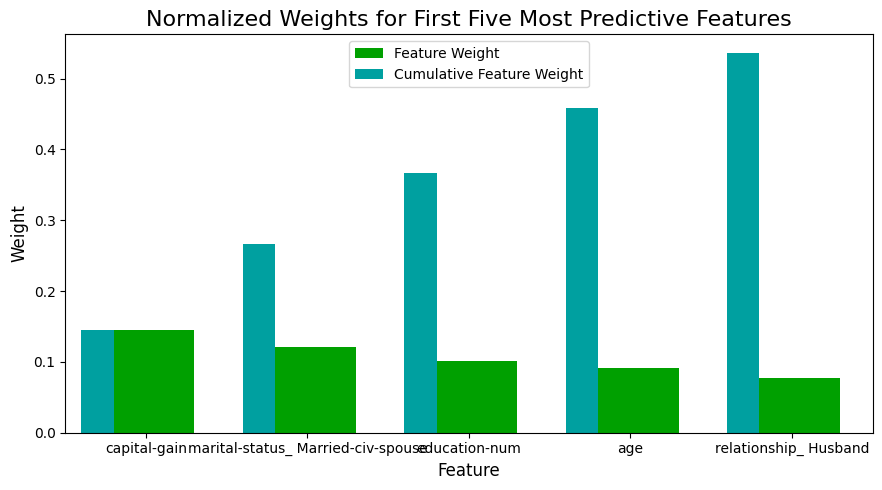

In [14]:
# Import the RandomForestClassifier and other necessary libraries
from sklearn.ensemble import RandomForestClassifier

# Initialize the RandomForestClassifier
model = RandomForestClassifier(random_state=42, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=200)

# Train the model on the entire training set
model.fit(X_train, y_train)

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
* How do these five features compare to the five features you discussed in **Question 6**?
* If you were close to the same answer, how does this visualization confirm your thoughts? 
* If you were not close, why do you think these features are more relevant?

**Answer:**

As an apriori intuition, the education level, age, occupation, capital gain/loss, and hours per week are all likely to have a strong influence on an individual's income.
However, the RF-based feature ranking reveals:
- age, education and capital gains => Correctly identified, though not ranked the same;
- marital status and relation/husband => New (and surprising at 1st sight...)

Speculative conjecture: Married couples are more likely to make 50K+ *and* to be more generous, both for altruistic (wife influence, e.g., Gates Foundation etc.) and tax reasons.

In the United States, married couples have the option to file their federal income taxes jointly or separately each year. When filing jointly, the couple reports their combined income and deductions on a single tax return. This can often result in a lower overall tax liability, as the couple can take advantage of certain tax benefits that are only available to joint filers. However, in some cases, it may be more beneficial for the couple to file separate returns, especially if one spouse has significant deductions or credits that would be limited on a joint return ¹.

It's important to note that the decision to file jointly or separately can affect other aspects of the couple's tax situation, such as their eligibility for certain tax credits and deductions. It's usually a good idea for married couples to calculate their taxes both ways (jointly and separately) to determine which filing status results in the lowest overall tax liability ².

- (1) How a taxpayer’s filing status affects their tax return. https://www.irs.gov/newsroom/how-a-taxpayers-filing-status-affects-their-tax-return.
- (2) A tax checklist for newly married couples - Internal Revenue Service. https://www.irs.gov/newsroom/a-tax-checklist-for-newly-married-couples.
- (3) Publication 504 (2022), Divorced or Separated Individuals. https://www.irs.gov/publications/p504.

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [15]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8617
F-score on testing data: 0.7329

Final Model trained on reduced data
------
Accuracy on testing data: 0.8428
F-score on testing data: 0.6881


### Question 8 - Effects of Feature Selection

* How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?
* If training time was a factor, would you consider using the reduced data as your training set?

**Answer:**

The final RF classifier trained on the reduced data using only the top **5 features has an accuracy of 0.8428 and an F-score of 0.6881** on the testing data. 
These scores are **quasi-similar to the LR model (default params, 30x faster inference)** and lower than those of the same model trained on the full data, which has an accuracy of 0.8617 and an F-score of 0.7329 on the testing data.

This suggests that using only the top 5 features results in a decrease in the performance of the model, as measured by both accuracy and F-score. This is not surprising, as removing features from the dataset can reduce the amount of information available to the model, potentially making it harder for the model to accurately predict the target variable.

If training time was a factor, using the reduced data as the training set could be a reasonable trade-off, as it would likely result in faster training times due to the smaller number of features. However, this would come at the cost of reduced performance, nearly identical to LR's - which has a lower CO2 footprint and much faster inference. 

Net: The decision to use the reduced data, or even switch to LR, would depend on the specific requirements of CharityML, such as their desired balance between prediction accuracy, computational efficiency, and training time.



> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.